In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [2]:
import survivors.datasets as ds
from survivors.tree import CRAID

param = {'criterion': 'peto', 'cut': True, 'depth': 10,
         'max_features': 1.0, 'min_samples_leaf': 5, 
         'signif': 0.05}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
param["categ"] = categ

# cr = CRAID(**param)
# cr.fit(X, y)

# pred_cens = cr.predict(X, target="cens")

In [12]:
categ

['trt', 'sex', 'ascites', 'hepato', 'spiders']

In [125]:
# def coxph_negative_gradient(cnp.npy_uint8[:] event,
#                             cnp.npy_double[:] time,
#                             cnp.npy_double[:] y_pred):
#     cdef cnp.npy_double s
#     cdef int i
#     cdef int j
#     cdef cnp.npy_intp n_samples = event.shape[0]

#     cdef cnp.ndarray[cnp.npy_double, ndim=1] gradient = cnp.PyArray_EMPTY(1, &n_samples, cnp.NPY_DOUBLE, 0)
#     cdef cnp.npy_double[:] exp_tsj = cnp.PyArray_ZEROS(1, &n_samples, cnp.NPY_DOUBLE, 0)

#     cdef cnp.npy_double[:] exp_pred = np.exp(y_pred)
#     with nogil:
#         for i in range(n_samples):
#             for j in range(n_samples):
#                 if time[j] >= time[i]:
#                     exp_tsj[i] += exp_pred[j]

#         for i in range(n_samples):
#             s = 0
#             for j in range(n_samples):
#                 if event[j] and time[i] >= time[j]:
#                     s += exp_pred[i] / exp_tsj[j]
#             gradient[i] = event[i] - s

#     return gradient

from numba import njit, jit

@jit  # ('f8(i8[:], f8[:], f8[:])')
def coxph_negative_gradient(event, time, y_pred):
    n_samples = event.shape[0]

    gradient = np.zeros(n_samples, dtype=float)
    exp_tsj = np.zeros(n_samples, dtype=float)

    exp_pred = np.exp(y_pred)
    for i in range(n_samples):
        for j in range(n_samples):
            if time[j] >= time[i]:
                exp_tsj[i] += exp_pred[j]

    for i in range(n_samples):
        s = 0
        for j in range(n_samples):
            if event[j] and time[i] >= time[j]:
                s += exp_pred[i] / exp_tsj[j]
        gradient[i] = event[i] - s

    return gradient

@jit
def fast_coxph_negative_gradient(event, time, y_pred):
    n_samples = event.shape[0]
    r = np.repeat(time[:, np.newaxis], n_samples, axis=1)
    exp_pred = np.exp(y_pred)
    exp_tsj = exp_pred.dot(r >= r.T)

    shared_j = event/exp_tsj
    gradient = event - exp_pred*shared_j.dot(r <= r.T)
    
    return gradient

In [128]:
%timeit coxph_negative_gradient(y["cens"], y["time"], pred_cens)

569 µs ± 4.47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [129]:
%timeit fast_coxph_negative_gradient(y["cens"], y["time"], pred_cens)

1.98 ms ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
np.vstack([y["cens"], pred_cens, grad]).T

array([[ 1.        ,  1.        ,  0.85628939],
       [ 0.        ,  0.16470588, -0.93795051],
       [ 1.        ,  0.625     ,  0.73621406],
       ...,
       [ 0.        ,  0.16470588, -0.16909675],
       [ 0.        ,  0.16470588, -0.09234032],
       [ 0.        ,  0.01724138, -0.13255543]])

In [29]:
np.nan * 0

nan

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [281]:
import numpy as np
from survivors.metrics import ibs, iauc, ipa, get_survival_func
from survivors.constants import get_y

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

bins = np.array([1, 10, 100, 1000])

y_train = get_y(np.array([1, 0]), np.array([100, 100]))
y_test_1 = get_y(np.array([1]), np.array([100]))
y_test_2 = get_y(np.array([0]), np.array([100]))
y_test_3 = get_y(np.array([1]), np.array([50]))

kmf_train = KaplanMeierFitter()
kmf_train.fit(y_train['time'], event_observed=y_train['cens'])
sf_train = kmf_train.survival_function_at_times(bins).to_numpy()[np.newaxis, :]

In [282]:
ibs(y_train, y_test_3, sf_train, bins)

0.23648648648648649

In [212]:
class KaplanMeier:
    def __init__(self):
        self.timeline = None
        self.survival_function = None
        self.confidence_interval_ = None
        self.alpha = 0.05

    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)
        self.hist_cens = np.bincount(dur_, weights=right_censor*weights)
        self.cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])

    def count_confidence_interval(self):
        ''' exponential Greenwood: https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf '''
        z = ss.norm.ppf(1 - self.alpha / 2)
        cumulative_sq_ = np.sqrt(np.hstack([0.0, np.cumsum(self.hist_cens / (self.cumul_hist_dur * (self.cumul_hist_dur - self.hist_cens)))]))
        np.nan_to_num(cumulative_sq_, copy=False, nan=0)
        v = np.log(self.survival_function)
        np.nan_to_num(v, copy=False, nan=0)
        self.confidence_interval_ = np.vstack([np.exp(v * np.exp(- z * cumulative_sq_ / v)),
                                               np.exp(v * np.exp(+ z * cumulative_sq_ / v))]).T
        np.nan_to_num(self.confidence_interval_, copy=False, nan=1)

    def get_confidence_interval_(self):
        if self.confidence_interval_ is None:
            self.count_confidence_interval()
        return self.confidence_interval_

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        return self.survival_function[np.clip(place_bin, 0, None)]

In [348]:
# @jit()
# def _brier_score(ti, t, s, g_t, g_ti, d):
#     if (ti <= t) and d == 1:
#         return np.power(s, 2) * 1./g_ti
#     if ti > t:
#         return np.power(1 - s, 2) * 1./g_t
#     return 0.

@jit()
def _brier_score(ti, t, s, g_t, g_ti, d):
    return np.where(ti > t, 
                    np.power(1 - s, 2) * 1./g_t, 
                    np.where(d == 1, 
                             np.power(s, 2) * 1./g_ti, 
                             0.0))

def _inverse_censoring_metric(func):
    def metric(survival_train, survival_test, estimate, times):
        ipcw = KaplanMeier()
        ipcw.fit(survival_train["time"], 1 - survival_train["cens"])
        g_t = ipcw.survival_function_at_times(times)
        g_ti = ipcw.survival_function_at_times(survival_test["time"])
        arr = np.zeros_like(estimate, dtype=float)
        
        for i, t in enumerate(times):
            arr[:,i] = func(survival_test["time"], t, estimate[:,i], g_t[i], g_ti, survival_test["cens"])
        return arr
    return metric

def _integrated_metric(func):
    def metric(survival_train, survival_test, estimate, times):
        scores = func(survival_train, survival_test, estimate, times)
        integral = np.trapz(scores, times)
        return integral / (times[-1] - times[0])
    return metric

In [349]:
ibs__ = _inverse_censoring_metric(_brier_score)

In [350]:
ibs_ = _integrated_metric(ibs__)

In [287]:
ibs_(y_train, y_test_3, sf_train, bins)

[[0.   0.   0.25 0.25]]


array([0.23648649])

In [312]:
from survivors.experiments.grid import generate_sample

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
gen = generate_sample(X, y, 5)
X_train, y_train, X_test, y_test, bins = next(gen)

cr = CRAID(**param)
cr.fit(X_train, y_train)

pred_sf = cr.predict_at_times(X_test, bins, mode="surv")

In [356]:
pred_hf = cr.predict_at_times(X_test, bins, mode="hazard")

In [353]:
%timeit ibs_(y_train, y_test, pred_sf, bins)

22.1 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [354]:
%timeit ibs(y_train, y_test, pred_sf, bins, axis=0)

31 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [355]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

def kl(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

In [357]:
loglikelihood(y_test["time"], y_test["cens"], pred_sf, pred_hf, bins)

-1099.563431516333

In [360]:
y_test["time"], bins
np.bincount(index_times)

array([ 0,  0,  0, ...,  0,  1, 12], dtype=int64)

In [390]:
# Kullback–Leibler divergence

index_times = np.digitize(y_test["time"], bins, right=True) - 1
arr = np.zeros_like(pred_hf, dtype=int)
arr[np.arange(arr.shape[0]), index_times] = 1
hf = np.hstack((pred_hf[:, 0][np.newaxis].T, np.diff(pred_hf)))

np.sum(hf * np.log((hf + 1e-20)/(arr + 1e-20)), axis=1)

array([103.07480247,  87.3916971 ,  36.01652794, 108.36656156,
        86.50062991,   0.        ,   5.05844785,  87.3916971 ,
        86.50062991,  86.50062991,  36.01652794, 103.07480247,
         0.        , 111.14680412,  87.3916971 ,   0.        ,
        86.50062991, 103.07480247,  87.3916971 , 103.07480247,
        36.01652794,  86.50062991,  86.50062991, 108.36656156,
         0.        ,  86.50062991, 103.07480247, 103.07480247,
        72.20241692,  86.50062991,  86.50062991, 108.36656156,
         0.        ,  87.3916971 ,  87.3916971 ,  72.20241692,
       103.07480247,  86.50062991,  36.01652794,  36.01652794,
        86.50062991, 108.36656156,  87.3916971 ,  86.50062991,
        72.20241692, 103.07480247,   0.        , 108.36656156,
        36.01652794,  36.01652794,  87.3916971 ,  87.3916971 ,
         0.        ,   0.        ,   5.05844785,   0.        ,
        72.20241692,  36.01652794,   0.        ,  68.7309792 ,
        68.7309792 ,  36.01652794,   0.        ,   0.  

In [394]:
def arc_x4(weights):
    scaled = 1 + weights**4
    return scaled/sum(scaled)

wei = np.array([-0.1, -1.2, -2.1, -3.5, -5.5])
arc_x4(wei)

array([0.00091614, 0.00281556, 0.01873142, 0.13838038, 0.83915649])

645.0

In [50]:
from survivors.ensemble import BoostingCRAID

def loglikelihood_i(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    return np.log(sf_by_times) + np.log(hf_by_times)

def values_to_hist(values):
    unq, idx = np.unique(values, return_inverse=True)
    # calculate the weighted frequencies of these indices
    freqs_idx = np.bincount(idx)
    # reconstruct the array of frequencies of the elements
    return freqs_idx[idx]

def arc_x4(weights):
    scaled = 1 + weights**4
    return scaled/sum(scaled)

class ProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "ProbBoostingCRAID"
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_weights = []
        self.update_params()
        
        for i in range(self.n_estimators):
            prob_weights = arc_x4(self.weights)
            x_sub = self.X_train.sample(n=self.size_sample, weights=prob_weights,  # self.weights
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = prob_weights[x_sub['ind_start']]  # self.weights

            model = CRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            
            # print(betta_i)
            self.ens_metr[i] = self.score_oob()
            
            if not (self.tolerance) and i > 0:
                print(f"METRIC: {self.ens_metr[i-1]} -> +1 model METRIC: {self.ens_metr[i]}")
                if self.descend_metr:
                    stop = self.ens_metr[i-1] < self.ens_metr[i]
                else:
                    stop = self.ens_metr[i-1] > self.ens_metr[i]
                if stop:
                    self.select_model(0, len(self.models)-1)
                    break
        
        if self.tolerance:
            self.tolerance_find_best()
        print('fitted:', len(self.models), 'models.')
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        pred_hf = model.predict_at_times(X_sub, bins=self.bins, mode="hazard")
        
        time_hist = values_to_hist(y_sub["time"])
        lp_ti = np.log(time_hist / y_sub["time"].shape)
        lp_xi_ti = np.log(1 / time_hist)
        likel = loglikelihood_i(y_sub["time"], y_sub["cens"], pred_sf, pred_hf, self.bins)
        
        lp_xi = lp_ti + lp_xi_ti - likel
        wei = - np.exp(-lp_xi)
        betta = np.sum(likel)
        return wei, betta
    
    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] - wei_i)
        # self.weights = self.weights / np.sum(self.weights)
        self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())
        
    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = -1 / np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

In [51]:
from survivors.experiments.grid import generate_sample

param = {
    "aggreg_func": 'wei',
    "criterion": "weights",
    "depth": 5, 
    "ens_metric_name": "roc",
    "max_features": "sqrt",
    "min_samples_leaf": 1,
    "n_estimators": 15,
    "size_sample": 0.5,
    "all_weight": False,
    "leaf_model": "base_fast"
}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
gen = generate_sample(X, y, 5)
X_train, y_train, X_test, y_test, bins = next(gen)

prb = ProbBoostingCRAID(**param)
prb.fit(X_train, y_train)

pred_sf = prb.predict_at_times(X_test, bins=bins, mode="surv")
pred_hf = prb.predict_at_times(X_test, bins=bins, mode="hazard")

np.sum(loglikelihood_i(y_test["time"], y_test["cens"], pred_sf, pred_hf, bins))

[0.6505 0.6904 0.7138 0.7394 0.7561 0.7691 0.7911 0.7886 0.7996 0.8016
 0.8043 0.8018 0.805  0.8084 0.8075]
fitted: 14 models.


-795.0394890758902

In [146]:
prb.bettas

[843.677177487109,
 1128.4243320246874,
 976.7412198817369,
 1124.4976005335884,
 773.0267519903804,
 1062.5846902799788,
 884.7021519288851,
 726.4325516435139,
 825.9051592548383,
 799.8801451723468,
 1014.1193201824256,
 932.0453037013289,
 1036.669474339849,
 1095.0846413858062,
 1080.4951369594746]

In [139]:
inv_wei = -1/np.array(prb.bettas)
wei = inv_wei/sum(inv_wei)
wei

array([0.0738521 , 0.05521622, 0.06379103, 0.05540904, 0.08060177,
       0.05863752, 0.07042746, 0.08577166, 0.07544126, 0.07789583,
       0.06143984, 0.06685011, 0.06010337, 0.05689727, 0.05766553])

In [119]:
pred_sf

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [70]:
def load_all_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
#     df = df[df["time"] < 4000].reset_index()
#     df["time"] = np.log(1 + df["time"])
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    categ = ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer']
    sign = list(set(df.columns) - set(['fac_type', cnt.CENS_NAME, cnt.TIME_NAME, 'pid']))
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

In [71]:
from lifelines import WeibullAFTFitter, CoxPHFitter

X, y, features, categ, sch_nan = load_all_hdfail_dataset()

X[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X = X.fillna(0)

model = CoxPHFitter()  # WeibullAFTFitter()
model.fit(X, cnt.TIME_NAME, cnt.CENS_NAME)
model.print_summary()

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\coxph_fitter.py:1608: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 51782 total observations, 48915 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 51782
number of events observed = 2867
   partial log-likelihood = -27423.34
         time fit was run = 2023-03-01 13:35:43 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
Weight                                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
num_temp                               -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
Required Power For Spinup               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Rotational Speed                        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Power Required (Seek)                   0.03       1.03       0.08            -0.13             0.19                 0.88                 1.21
Number Of Heads                         0.09       1.09       0.46            -0.82             1.00                 0.44                 2.71
Disk Interface                          1.28       3.59       1.77            -2.20             4.75                 0.11               116.12
Full Stroke Seek Time                   0.04       1.04       0.05            -0.06             0.13                 0.95                 1.14
index                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Buffer-Host Max. Rate                   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
Number Of Disks                        -0.38       0.68       0.95            -2.23             1.47                 0.11                 4.36
Power Required (Idle)                  -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.24
Buffer Size                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Average Rotational Latency            -17.70       0.00      51.54          -118.73            83.32                 0.00             1.54e+36
Form Factor                            29.86   9.28e+12      47.86           -63.95           123.67                 0.00             5.13e+53
Rotation Time                           8.80    6604.07      25.73           -41.64            59.23                 0.00             5.30e+25
Acoustic (Idle)                         0.13       1.14       1.75            -3.29             3.56                 0.04                35.29
Capacity                                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Acoustic (Min performance and volume)   1.18       3.24       1.96            -2.67             5.02                 0.07               151.08
Acoustic (Max performance and volume)  -1.21       0.30       0.85            -2.88             0.45                 0.06                 1.57
Depth                                   0.48       1.61       0.49            -0.48             1.43                 0.62                 4.20
Average Seek Time                       0.03       1.03       0.03            -0.03             0.09                 0.97                 1.09
Width                                  -1.70       0.18       1.49            -4.61             1.21                 0.01                 3.37
Manufacturer                            0.19       1.21     

In [74]:
np.bincount(y["cens"])

array([48915,  2867], dtype=int64)

In [556]:
def loglikelihood_i(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10) ** cens
    return np.log(sf_by_times) + np.log(hf_by_times)


def values_to_hist(values):
    unq, idx = np.unique(values, return_inverse=True)
    # calculate the weighted frequencies of these indices
    freqs_idx = np.bincount(idx)
    # reconstruct the array of frequencies of the elements
    return freqs_idx[idx]


class ProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "ProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        pred_hf = model.predict_at_times(X_sub, bins=self.bins, mode="hazard")

        time_hist = values_to_hist(y_sub["time"])
        lp_ti = np.log(time_hist / y_sub["time"].shape)
        lp_xi_ti = np.log(1 / time_hist)
        likel = loglikelihood_i(y_sub["time"], y_sub["cens"], pred_sf, pred_hf, self.bins)

        lp_xi = lp_ti + lp_xi_ti - likel
        wei = - np.exp(-lp_xi)
        betta = np.sum(likel)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
        self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = -1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

### COMPARISON OF RSF AND GRBOOST ON ONK

In [482]:
X, y, features, categ, sch_nan = ds.load_onk_dataset()

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}


In [217]:
from sklearn.model_selection import train_test_split

def prepare_sample(X, y, train_index, test_index):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    bins = cnt.get_bins(time=y_train[cnt.TIME_NAME], cens=y_train[cnt.CENS_NAME])
    y_train[cnt.TIME_NAME] = np.clip(y_train[cnt.TIME_NAME], bins.min() - 1, bins.max() + 1)
    y_test[cnt.TIME_NAME] = np.clip(y_test[cnt.TIME_NAME], bins.min(), bins.max())
    return X_train, y_train, X_test, y_test, bins

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins = prepare_sample(X, y, X_TR.index, X_HO.index)

In [400]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gb_params = {'learning_rate': 0.5, 'loss': 'coxph', 
             'max_depth': 20, 'max_features': 'sqrt', 
             'min_samples_leaf': 20, 'n_estimators': 100, 'random_state': 123}

gbsa = GradientBoostingSurvivalAnalysis(**gb_params)

X_tr_gb = X_tr.fillna(0).replace(np.nan, 0)
X_HO_gb = X_HO.fillna(0).replace(np.nan, 0)

gbsa.fit(X_tr_gb, y_tr)
survs = gbsa.predict_survival_function(X_HO_gb)
hazards = gbsa.predict_cumulative_hazard_function(X_HO_gb)

tr_survs = gbsa.predict_survival_function(X_tr_gb)
tr_pred_surv_gbsa = np.array(list(map(lambda x: x(bins), tr_survs)))

pred_surv_gbsa = np.array(list(map(lambda x: x(bins), survs)))
pred_haz_gbsa = np.array(list(map(lambda x: x(bins), hazards)))
pred_time_gbsa = -1*gbsa.predict(X_HO_gb)

In [761]:
proboost_params = {'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'tarone-ware', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.5, 'min_samples_leaf': 10, 
                   'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.7}

proboost = ProbBoostingCRAID(**proboost_params)
proboost.fit(X_tr, y_tr)

[0.2164 0.1783 0.1665 0.1673 0.1628 0.163  0.1633 0.1609 0.1599 0.1565
 0.1561 0.1548 0.1524 0.1512 0.1497 0.1496 0.1478 0.1456 0.1446 0.1453
 0.1445 0.1444 0.1444 0.1441 0.1439 0.1432 0.143  0.1422 0.1416 0.1408
 0.1411 0.141  0.1403 0.1398 0.1395 0.139  0.1397 0.1395 0.1392 0.1393
 0.1391 0.1391 0.1387 0.1385 0.1385 0.1385 0.1385 0.1382 0.1382 0.1384
 0.1382 0.1382 0.1382 0.1382 0.1383 0.1383 0.138  0.138  0.1383 0.1382
 0.138  0.138  0.138  0.138  0.138  0.1382 0.1381 0.1381 0.1382 0.1382
 0.1381 0.1378 0.1376 0.1376 0.1372 0.1369 0.1369 0.1368 0.1366 0.1367
 0.1368 0.1367 0.1367 0.1366 0.1363 0.1363 0.1363 0.1364 0.1363 0.1364
 0.1365 0.1365 0.1365 0.1364 0.1364 0.1364 0.1362 0.1361 0.1361 0.1361
 0.1361 0.1362 0.1362 0.1362 0.1362 0.1363 0.1365 0.1366 0.1368 0.1367
 0.1366 0.1367 0.1367 0.1366 0.1367 0.1364 0.1364 0.1364 0.1364 0.1363
 0.1364 0.1364 0.1363 0.1361 0.1361 0.136  0.1359 0.1358 0.1359 0.136
 0.136  0.1359 0.1359 0.1357 0.1357 0.1358 0.1357 0.1356 0.1356 0.1356
 0.1355

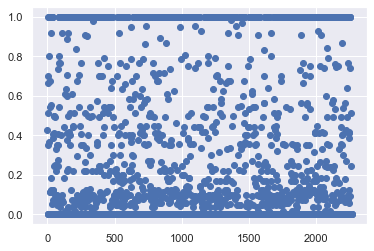

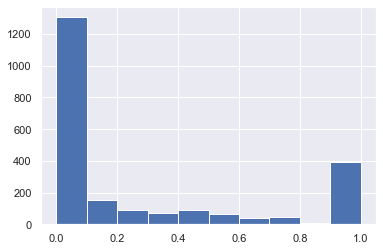

In [762]:
plt.scatter(np.arange(proboost.weights.shape[0]), proboost.weights)
plt.show()
plt.hist(proboost.weights)
plt.show()

In [763]:
# for w in proboost.l_weights[:10]:
#     plt.figure(figsize=(14, 7))
#     plt.scatter(range(w.shape[0]), w, alpha=0.5)
#     plt.show()

In [764]:
# # pred_bettas = proboost.bettas.copy()
# proboost.bettas = pred_bettas.copy()
# proboost.bettas = proboost.bettas - np.linspace(0, 3000, len(proboost.bettas))

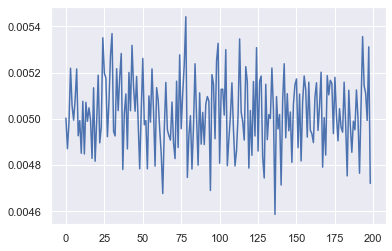

In [765]:
inv_wei = -1/np.array(proboost.bettas)
plt.plot(inv_wei/sum(inv_wei))

In [766]:
tr_pred_surv_proboost = proboost.predict_at_times(X_tr, bins=bins, mode="surv")

pred_surv_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="surv")
pred_time_proboost = proboost.predict(X_HO, target=cnt.TIME_NAME)
pred_haz_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="hazard")

In [767]:
print("TRAIN GB:", metr.ibs(y_tr, y_tr, tr_pred_surv_gbsa, bins, axis=-1))
print("TRAIN PR:", metr.ibs(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=-1))

print("TEST GB:", metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=-1))
print("TEST PR:", metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))

ibs_gbsa_obs = metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=0)
ibs_proboost_obs = metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0)

TRAIN GB: 0.040758365855872156
TRAIN PR: 0.08248698469300031
TEST GB: 0.11512669052794938
TEST PR: 0.1273250272043748


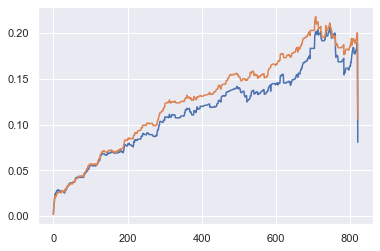

In [768]:
plt.plot(metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=1))
plt.plot(metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=1))

In [769]:
import matplotlib.pyplot as plt

def print_true_pred(y_true, y_preds, labels):
    fig, ax = plt.subplots()
    
    for y_pred, label in zip(y_preds, labels):
        ax.plot(y_pred, label = label)
    ax.hlines(1.0, 0, y_true["time"], color = 'r')
    ax.hlines(0.0, y_true["time"], len(y_preds[0]), color = 'r')
    ax.vlines(y_true["time"], 0, 1, 
                  color = 'r', 
                  linestyles = ('solid' if y_true["cens"] else 'dashed'),
                  linewidth = 2, 
                  label = "True")
    ax.legend()
    plt.show()

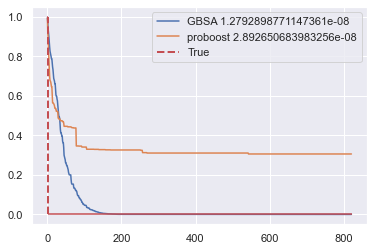

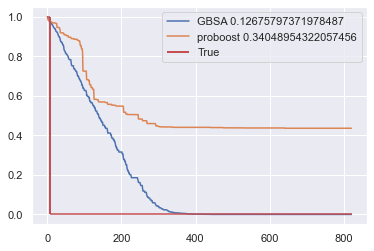

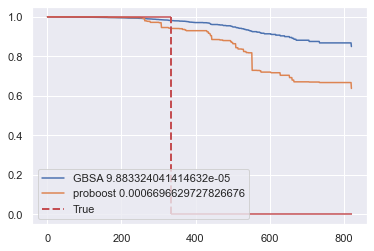

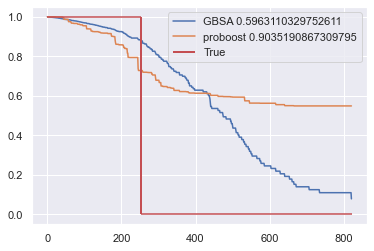

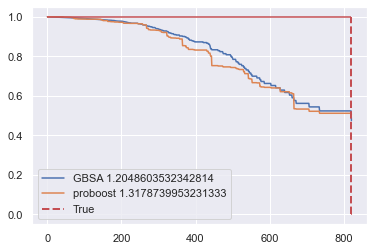

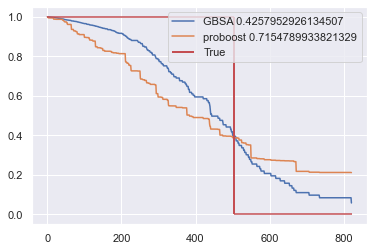

In [770]:
for i in [0, 1, 10, 25, 100, 262]:
    print_true_pred(y_HO[i], 
                    [pred_surv_gbsa[i], 
                     pred_surv_proboost[i]],
                    [f"GBSA {ibs_gbsa_obs[i]}", 
                     f"proboost {ibs_proboost_obs[i]}"])

#### Выводы

1. ibs ниже для 'all_weight': True (до 0.128)
2. Веса моделей без зависимостей
3. Веса наблюдений почти одинаковы
4. При искусственной регуляризации на поздние деревья прогноз не меняется.
5. Не может обучиться на тренировочной

TRAIN GB: 0.040758365855872156

TRAIN PR: 0.08463218453732083

TEST GB: 0.11512669052794938

TEST PR: 0.13008129686938671

6. Самые важные по gbsa (>0.05): ['Вес', 'Рост', 'Возраст', 'Индекс_массы', 'Диагноз',
    'Кол_во_Лекарственная_противоопухолевая_терапия',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Первая_линия']

In [480]:
# gbsa.feature_importances_[np.argsort(gbsa.feature_importances_)[::-1]]
X_tr.columns[gbsa.feature_importances_ > 0.05]

Index(['Вес', 'Рост', 'Возраст', 'Индекс_массы', 'Диагноз',
       'Кол_во_Лекарственная_противоопухолевая_терапия',
       'Кол_во_Лекарственная_противоопухолевая_терапия_Первая_линия'],
      dtype='object')